# Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn import metrics
from tslearn.matrix_profile import MatrixProfile
import time

## A time series created by tracking the left-hand of a volunteer (Fig. 15)

![datahand](hand_move.png)

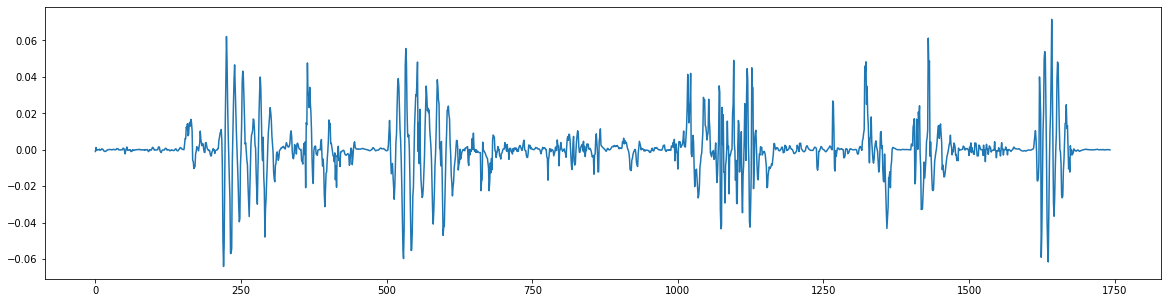

In [2]:
data_hand = np.loadtxt('dataset/a1va3.txt')[1:,1]
plt.figure(figsize=(20,5))
plt.plot(data_hand)
plt.show()

## A time series created by a hip-worn gyroscope (Fig. 16)

![datahip](gyroscope.png)

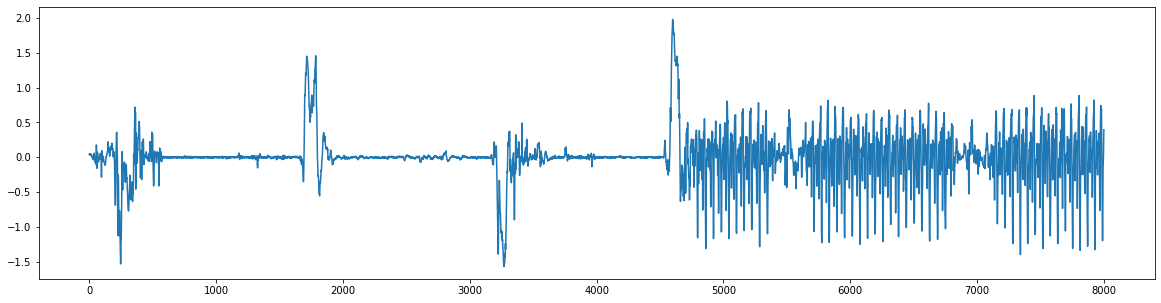

In [3]:
data_hip = np.loadtxt('dataset/gyroexp61user30_selected.txt')
plt.figure(figsize=(20,5))
plt.plot(data_hip)
plt.show()

# Code for SWAMP

## Table 2 LBKeoghDSMP

In [127]:
def cal_mean_var(T, L):
    means_list = []
    vars_list = []
    for i in range(len(T)-L+1):
        means_list.append(np.mean(T[i:i+L]))
        vars_list.append(np.var(T[i:i+L]))
    return means_list, vars_list

In [128]:
# Calculate upper and lower envelope 
def cal_envelop(T, w):
    Up = np.zeros_like(T)
    Low = np.zeros_like(T)
    pruned = np.zeros_like(T).astype('bool')

    for i in range(len(T)):
        left = max(0, i-w)
        right = min(len(T), i+w+1)
        Up[i] = np.max(T[left:right])
        Low[i] = np.min(T[left:right])
    return Up, Low

In [129]:
def paa(T, D):
    #T is a numpy float array or a numpy boolean array
    l = len(T)
    l_D = int(np.ceil(l/D))
    T_D = np.zeros(l_D)
    
    if type(T[0]) == np.bool_:
        T_D = T_D.astype('bool')
        for i in range(l_D):
            T_D[i] = np.all(T[i*D: (i+1)*D])
    elif type(T[0]) == np.float_:
        for i in range(l_D):
            T_D[i] = np.mean(T[i*D: (i+1)*D])
    else:
        raise AssertionError('Input should be a numpy array contians np.bool_ or np.float_')
    return T_D

In [130]:
# Calculate Keogh lowerbound for T and the envelopes around Q
def LB_Keo_dis(T, Up, Low, mi, mj, vi, vj):
    if vi==0:
        vi = 0.01
    if vj==0:
        vj = 0.01
        
    T = (T-mi)/np.sqrt(vi)
    Up = (Up-mj)/np.sqrt(vj)
    Low = (Low-mj)/np.sqrt(vj)
    
    diff = np.maximum(T-Up, Low-T)
    diff = np.maximum(diff, np.zeros_like(T))
    return np.sqrt(np.sum(diff**2))
    

In [131]:
#Using library
# Calculate Keogh lowerbound for T and the envelopes around Q
def LB_Keo_dis_lib(A, B, w, mi, mj, vi, vj):
    if vi==0:
        vi = 0.01
    if vj==0:
        vj = 0.01
        
    A = (A-mi)/np.sqrt(vi)
    B = (B-mj)/np.sqrt(vj)
    
    return metrics.lb_keogh(A, B, radius=w)

In [132]:
def LB_Keo_MP(T, L, w, pruned, Up, Low, mean_l, var_l):
    MP = float('inf') * np.ones(len(T)-L+1)
    LB_index = -1 * np.ones_like(MP).astype('int')
    
    # Calculate the lowest Keogh lowerbound for T_i,L
    for i in np.argwhere(pruned==False).squeeze():
        if i>=len(MP): continue 
        # Calculate Keogh lowerbound for all T_i,L and T_j, L
        #for j in range(len(MP)):
        for j in np.argwhere(pruned==False).squeeze():
            if j>=len(MP) or abs(i-j)<L: continue
            dis = LB_Keo_dis(T[i: i+L], Up[j: j+L], Low[j: j+L], mean_l[i], mean_l[j], var_l[i], var_l[j])
            #dis = LB_Keo_dis_lib(T[i: i+L], T[j: j+L], w, mean_l[i], mean_l[j], var_l[i], var_l[j])
            
            if dis < MP[i]:
                MP[i] = dis
                LB_index[i] = j     
    return MP, LB_index

In [133]:
# code for table 2
def LB_DSMP(T, L, D, pruned, Up, Low):
    T_D = paa(T, D)
    pruned_D = paa(pruned, D)
    L_D = int(np.floor(L*len(T_D)/len(T)))
    Up_D = paa(Up, D)
    Low_D = paa(Low, D)
    mean_l, var_l = cal_mean_var(T_D, L_D)
    #w_D = int(np.ceil(w*len(T_D)/len(T)))
    
    MP_D, LB_index = LB_Keo_MP(T_D, L_D, w, pruned_D, Up_D, Low_D ,mean_l, var_l)
    
    LBMP = np.repeat(MP_D, D)[:len(T)]
    LB_index = D * np.repeat(LB_index, D)[:len(T)]
    
    LBMP *= np.sqrt(len(T)/len(T_D))
    
    return LBMP, LB_index    

Check whether the lowerbound is correct

In [134]:
with open('DTW_mp.npy', 'rb') as f:
    DTW_mp = np.load(f)

In [135]:
L = 160
T = data_hand[:1000]
w = 8
Up, Low = cal_envelop(T, w)
pruned = np.zeros_like(T).astype('bool')

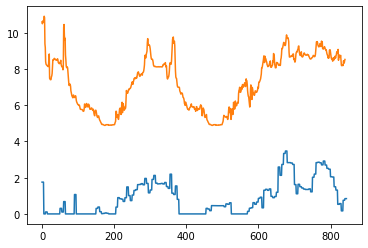

In [136]:
MP2, LB_index2 = LB_DSMP(T, L, 5, pruned, Up, Low)
plt.plot(MP2)
plt.plot(DTW_mp)
plt.show()

## Table 1 ComputeDSMP

In [137]:
# Using Euclidean Distance to calculate matrix profile
# Here is a simple version. Furthur we can use FFT to speed up
def ComputeMatrixProfile(T, L):
    #time series T, subsequence length L
    mat_prof = MatrixProfile(subsequence_length=L, implementation='numpy', scale=True)
    ED_mp = mat_prof.fit_transform(T.reshape((1,-1, 1))).squeeze()
    return ED_mp
    

In [138]:
# Calculate DTW distance between A and B
def dtw_distance(A, B, w, A_mean, B_mean, A_var, B_var):
    # time series A and B, warping window size w
    A = (A-A_mean)/np.sqrt(A_var)
    B = (B-B_mean)/np.sqrt(B_var)
    dis = metrics.dtw(A, B, global_constraint="sakoe_chiba", sakoe_chiba_radius=w)
    return dis

In [139]:
MP_list = []
D_list = []
def ComputeDSMP(T, L, w, ml, vl):
    #time series T, subsequence length L, warping window size w
    ED_mp = ComputeMatrixProfile(T, L)
    ED_i, ED_j = np.where(ED_mp==np.min(ED_mp))[0]

    best_so_far = dtw_distance(T[ED_i: ED_i+L], T[ED_j: ED_j+L], w, ml[ED_i], ml[ED_j], vl[ED_i], vl[ED_j])
    
    D = L
    pruned = np.zeros_like(T).astype('bool')
    Up, Low = cal_envelop(T, w)
    
    while D>0:
        print('D=', D)
        LBMP, LB_index = LB_DSMP(T, L, D, pruned, Up, Low)
        LB_motif_dist = np.min(LBMP)
        plt.plot(LBMP)
        plt.plot(DTW_mp)
        MP_list.append(LBMP)
        D_list.append(D)
        #plt.plot(test_mp)
        plt.show()
        print(best_so_far)
        print(np.sum(pruned))
        if LB_motif_dist < best_so_far:
            pruned[np.where(LBMP > best_so_far)[0]] = True
            
            for LB_i in np.argwhere(pruned==False).squeeze():
                if LB_i >= len(T)-L+1: break 
                LB_j = LB_index[LB_i]
                
                if LB_j >= len(T)-L+1: continue 
                
                if abs(LB_i-LB_j)>L:
                    a = T[LB_i: LB_i+L]
                    b = T[LB_j: LB_j+L]
                    dtw_dis = dtw_distance(a, b, w, ml[LB_i], ml[LB_j], vl[LB_i], vl[LB_j])
                    best_so_far = min(best_so_far, dtw_dis)
                
        D = int(np.floor(D/2))
    return LBMP, pruned, best_so_far, LB_index

D= 160


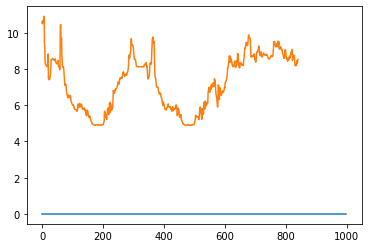

8.06793422939817
0
D= 80


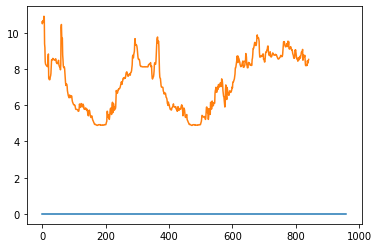

8.06793422939817
0
D= 40


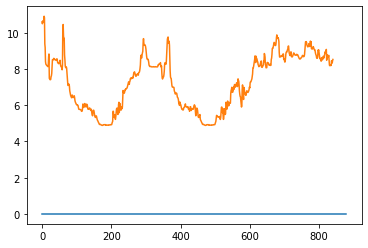

6.7954628452765755
0
D= 20


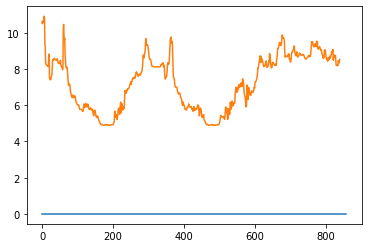

6.7954628452765755
0
D= 10


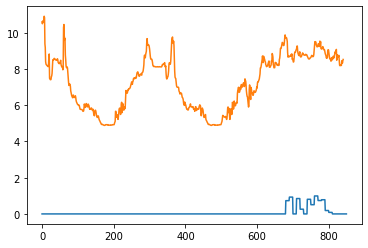

4.923977210976888
0
D= 5


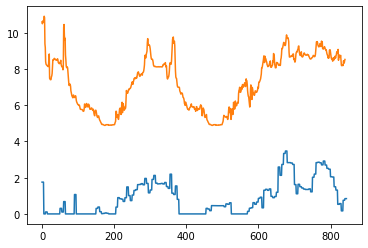

4.923977210976888
0
D= 2


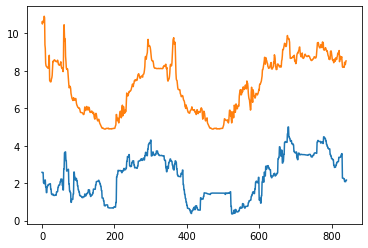

4.923977210976888
0
D= 1


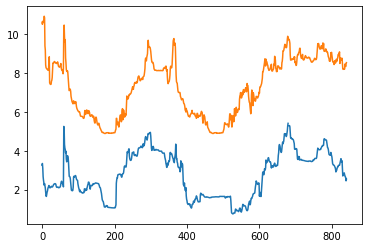

4.923977210976888
2


In [140]:
ml, vl = cal_mean_var(T, L)
LBMP,pruned, best_so_far ,LB_index = ComputeDSMP(T, L, w, ml, vl)

In [141]:
np.sum(pruned)

13

In [142]:
pruned[174]
pruned[472]

False

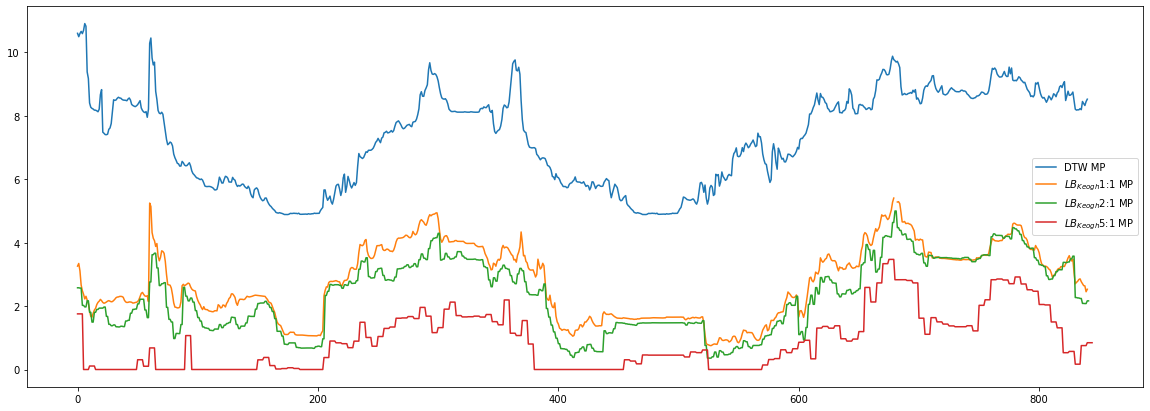

In [143]:
plt.figure(figsize=(20,7))
plt.plot(DTW_mp, label='DTW MP')
for i in range(3):
    label = '$LB_{Keogh}$'+str(D_list[-i-1])+':1 MP'
    plt.plot(MP_list[-i-1], label=label)

plt.legend()
plt.show()

## Table 3 SWAMP

In [71]:
def LB_Kim_dis(A, B, mi, mj, vi, vj):
    A = (A-mi)/np.sqrt(vi)
    B = (B-mj)/np.sqrt(vj)
    dis = (A[0]-B[0])**2+(A[-1]-B[-1])**2
    return np.sqrt(dis)

In [72]:
def SWAMP(T, L, w):
    ml, vl = cal_mean_var(T, L)
    Up, Low = cal_envelop(T, L)
    
    start = time.time()
    LBMP,pruned, best_so_far ,LB_index = ComputeDSMP(T, L, w, ml, vl)
    stop = time.time()
    print("ComputeDSMP Finish!")
    print('\t time {:.4f}'.format(stop - start))
    print(np.sum(pruned))
    
    start = time.time()
    candids, candids_index = np.array(sorted(LBMP)), np.array(sorted(range(len(LBMP)), key=lambda k: LBMP[k]))
    for i in range(len(candids)):
        candid_idx = candids_index[i]
        if candid_idx>len(T)-L+1: continue
        if pruned[candid_idx]: continue
        
        neigh_idx = np.array([idx for idx in range(candid_idx+L, len(candids-L+1))])
        
        if LB_index[candid_idx]>candid_idx+L and LB_index[candid_idx]>0:
            n_id = LB_index[candid_idx]-candid_idx-L
            neigh_idx[0], neigh_idx[n_id] = neigh_idx[n_id], neigh_idx[0]
        for j in range(len(neigh_idx)):
            if neigh_idx[j]>len(T)-L+1: 
                continue
            if pruned[neigh_idx[j]]: 
                continue
            a = T[candid_idx:candid_idx+L]
            b = T[neigh_idx[j]:neigh_idx[j]+L]
            ma = ml[candid_idx]
            va = vl[candid_idx]
            mb = ml[neigh_idx[j]]
            vb = vl[neigh_idx[j]]
            
            if LB_Kim_dis(a,b,ma,mb,va,vb) > best_so_far:
                continue
            #LB_Keo = LB_Keo_dis(a, Up[neigh_idx[j]:neigh_idx[j]+L],Low[neigh_idx[j]:neigh_idx[j]+L],ma,mb,va,vb)
            LB_Keo = LB_Keo_dis_lib(a,b,w,ma,mb,va,vb)
            if  LB_Keo > best_so_far:
                continue
            dist = dtw_distance(a,b,w,ma,mb,va,vb)
            if dist <= best_so_far:
                best_so_far = dist
                motif_pair = [candid_idx, neigh_idx[j]]
                pruned[np.where(LBMP > best_so_far)[0]] = True
    
    stop = time.time()
    print("All Finish!")
    print('\t time {:.4f}'.format(stop - start))
    return motif_pair, best_so_far

D= 160


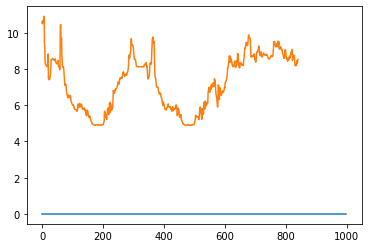

8.06793422939817
0
D= 80


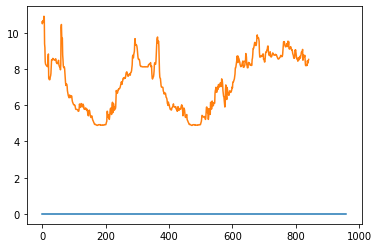

8.06793422939817
0
D= 40


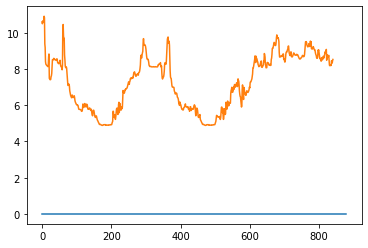

6.7954628452765755
0
D= 20


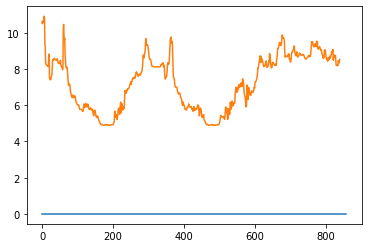

6.7954628452765755
0
D= 10


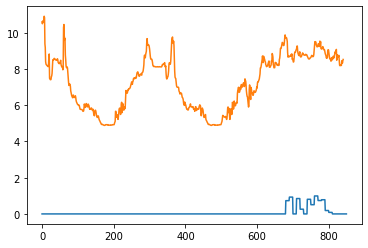

4.923977210976888
0
D= 5


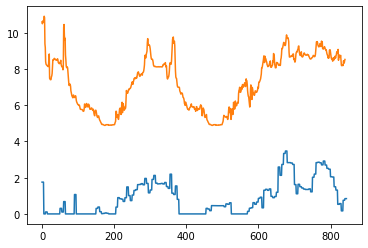

4.923977210976888
0
D= 2


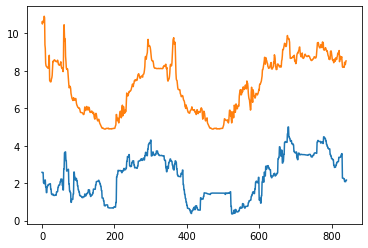

4.923977210976888
0
D= 1


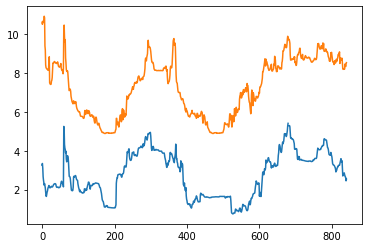

4.923977210976888
2
ComputeDSMP Finish!
	 time 24.3522
13
All Finish!
	 time 20.4582


In [126]:
result = SWAMP(data_hand[:1000], 160, 8)

In [121]:
result

([113, 408], 5.940140170340126)

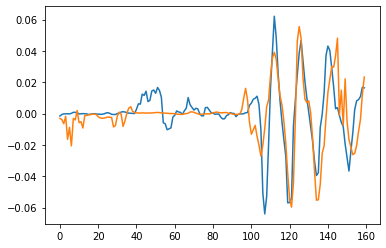

In [122]:
d_i, d_j = result[0]
plt.plot(data_hand[d_i:d_i+160])
plt.plot(data_hand[d_j:d_j+160])

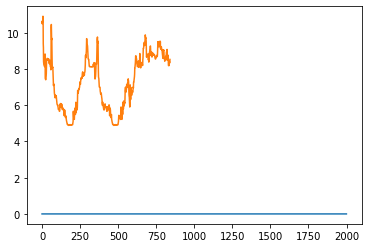

2.8341232553974907
0


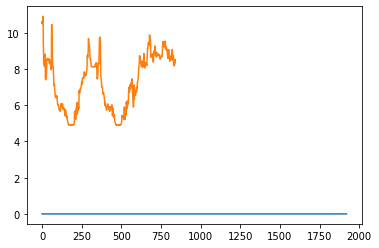

2.8341232553974907
0


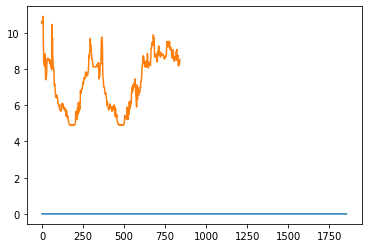

2.8341232553974907
0


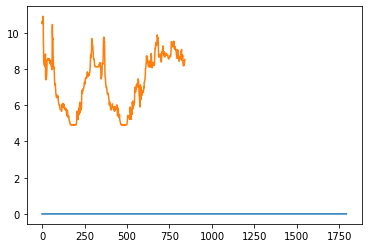

2.8341232553974907
0


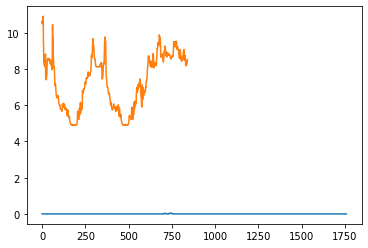

2.8341232553974907
0


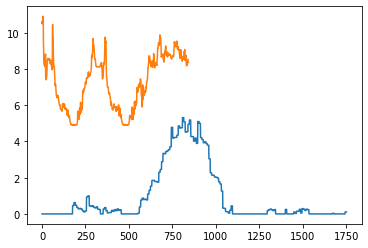

2.8341232553974907
0


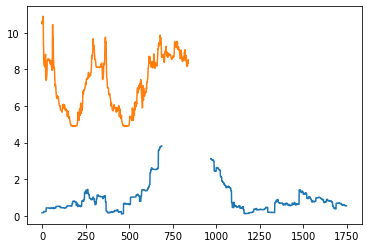

2.8341232553974907
280


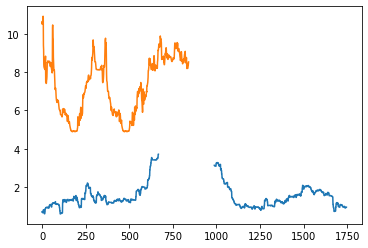

2.5981919222288576
320


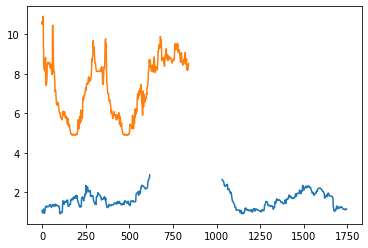

2.5981919222288576
414
ComputeDSMP Finish!
	 time 59.7889
423
All Finish!
	 time 40.1164


In [75]:
result = SWAMP(data_hip[-2000:], 256, 4)

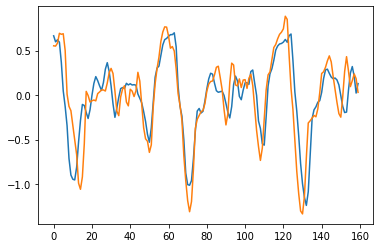

In [76]:
d_i, d_j = result[0]
d_i-=2000
d_j-=2000
plt.plot(data_hip[d_i:d_i+160])
plt.plot(data_hip[d_j:d_j+160])